In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import category_encoders as ce

In [2]:
df_input = pd.read_csv('./data/train.csv')
df_input.pop('Id')

0         1
1         2
2         3
3         4
4         5
       ... 
995     996
996     997
997     998
998     999
999    1000
Name: Id, Length: 1000, dtype: int64

In [3]:
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(df_input)
df_encoded.tail()

,BldgType_1Fam,BldgType_2FmCon,BldgType_Duplx,BldgType_TwnhsE,BldgType_TwnhsI,OverallQual,GrLivArea,GarageArea,SalePrice
995,1,0,0,0,0,4,1230,305,121600
996,1,0,0,0,0,5,1050,368,136500
997,1,0,0,0,0,6,1442,615,185000
998,1,0,0,0,0,3,1077,210,91000
999,1,0,0,0,0,7,1208,632,206000


In [4]:
x_train = df_encoded.sample(frac=0.8,random_state=0)
x_test = df_encoded.drop(x_train.index)

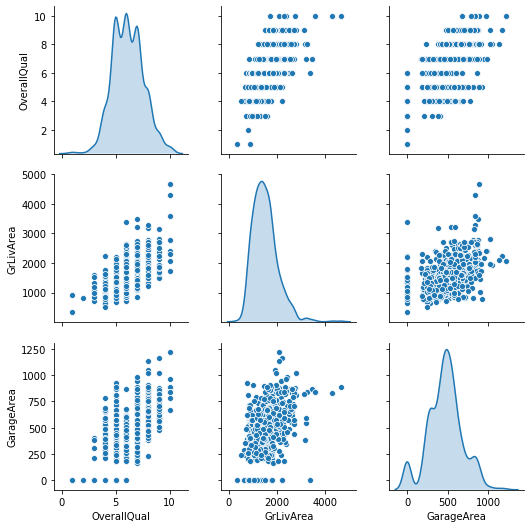

In [5]:
sns.pairplot(x_train[["OverallQual", "GrLivArea", "GarageArea"]], diag_kind="kde")

In [6]:
y_train = x_train.pop('SalePrice')
y_test = x_test.pop('SalePrice')

In [7]:
train_stats = x_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
BldgType_1Fam,800.0,0.83875,0.367991,0.0,1.00,1.0,1.00,1.0
BldgType_2FmCon,800.0,0.01875,0.135726,0.0,0.00,0.0,0.00,1.0
BldgType_Duplx,800.0,0.03875,0.193119,0.0,0.00,0.0,0.00,1.0
BldgType_TwnhsE,800.0,0.07375,0.261527,0.0,0.00,0.0,0.00,1.0
BldgType_TwnhsI,800.0,0.03000,0.170694,0.0,0.00,0.0,0.00,1.0
OverallQual,800.0,6.15625,1.404208,1.0,5.00,6.0,7.00,10.0
GrLivArea,800.0,1519.81250,514.256850,334.0,1144.75,1456.0,1776.75,4676.0
GarageArea,800.0,472.35375,210.261512,0.0,336.00,480.0,576.00,1220.0


In [8]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_x_train = norm(x_train)
normed_x_test = norm(x_test)

In [23]:
def build_model():
    model = keras.Sequential([
        layers.Dense(1, activation='linear', input_shape=[len(x_train.keys())])
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [24]:
model = build_model()

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [26]:
# example_batch = normed_train_data[:10]
# example_result = model.predict(example_batch)
# example_result

In [27]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)



history = model.fit(
  normed_x_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,4.196660e+10,185816.718750,4.196660e+10,3.608843e+10,178188.750000,3.608843e+10,995
996,4.196658e+10,185816.703125,4.196658e+10,3.608842e+10,178188.734375,3.608842e+10,996
997,4.196657e+10,185816.671875,4.196657e+10,3.608841e+10,178188.718750,3.608841e+10,997
998,4.196655e+10,185816.656250,4.196656e+10,3.608840e+10,178188.703125,3.608840e+10,998
999,4.196654e+10,185816.609375,4.196654e+10,3.608839e+10,178188.671875,3.608839e+10,999


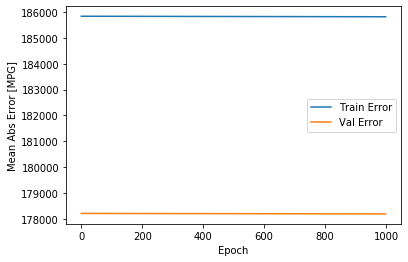

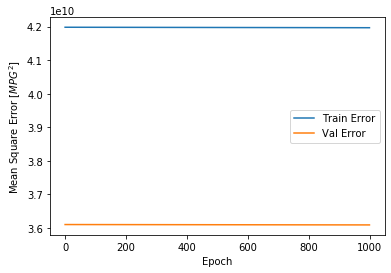

In [29]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    # plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  # plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

In [31]:
newdata = df_encoded
# new_label = newdata.pop('SalePrice')
normed_train = norm(newdata)

In [32]:
new_predict = model.predict(normed_train)
new_predict = new_predict.astype(int)

In [33]:
df = pd.DataFrame({'Actual': new_label, 'Predicted': new_predict.flatten()})
df

,Actual,Predicted
0,208500,48
1,181500,15
2,223500,55
3,140000,55
4,250000,98
...,...,...
995,121600,-22
996,136500,-10
997,185000,32
998,91000,-46


In [35]:
((df.Actual - df.Predicted) ** 2).mean()

39654725501.409